# ***rfpred*** 🧪
## Notebook 2 📊

# 5. Machine Learning Models for TLC Prediction

To predict the Rf value, we explored several strategies and techniques. They can be divided into three main approaches: 

1. Morgan Fingerprint & RDKit Descriptor based Approach
2. ChemBERTa embeddings based approach
3. MACCS KEys and solvent-encoded approach

In more detail this included:  

1. Morgan
    - Conversion of SMILES extracted from XML files into Morgan Fingerprints with a radius of 2 and 2048 bits for both compounds and solvents.
    - Variation of Morgan fingerprint parameters: decreasing solvent fingerprint size to 256 bits and increasing radius to 3 to capture larger substructural information.
    - Concatenation of fingerprint features with solvent ratios and input into a fully connected neural network (FCNN).
    - Experimentation with different activation functions, ultimately selecting a hard-sigmoid activation function for the output layer to mitigate saturation issues of the sigmoid function.
    - Exploration of deeper FCNN architectures and FCNN with self-attention to address stagnating loss functions.
    - Utilization of different models such as Random Forest Regressors, XGBoost Regressors, Light Gradient Boosting Regressor, and an embedded neural network to reduce input feature dimensionality and increase performance.
    - Concatenation of fingerprints with selected rdkit descriptors based on their suggested importance in TLC.

2. ChemBERTa
    - Introduction of ChemBERTa, a transformer-based model trained on SMILES, for alternative feature input. SMILES were tokenized and fed into the ChemBERTa model to learn embeddings and generate featurized vectors.

3. MACCS 
    - Exploration of MACCS keys and "multi-hot encoding" for solvent representation, where solvents are described by a single feature vector indicating presence and ratio.
    - Application of ensemble learning by stacking different models to improve prediction accuracy.

Despite these efforts, an optimized Light GBM model with the third approach emerged as the most effective, achieving a coefficient of determination of 0.56. This is still not great but after so much trying we had to accept, that the data maybe too subjective, as we will detail in the end.

This section provides a comprehensive overview of our training process, highlighting the various methodologies and strategies employed to enhance prediction accuracy. One thing from the start: this is a looong notebook, as I tried many different things, also to learn more about different models and strategies. The model which is finally used is a LightGBM in the MACCS Section. 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, Descriptors, rdChemReactions, rdmolops, MACCSkeys
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetRegressor
from transformers import AutoTokenizer, AutoModel
import lightgbm as lgb
import xgboost as xgb

## 5.1 Feature Selection and Preparation

### Some Functions

In [2]:
def create_fingerprints(df: pd.DataFrame, column_name: str):
    """Function that creates Morgan Fingerprint and RDKit Fingerprints for the extracted product molecules in the dataframe.

    Args:
        df (pd.DataFrame): dataframe containing the cleaned and extracted product SMILES
        column_name (str): column name of the SMILES column to be converted
    """
    radius = 3 # Radius of the fingerprint
    
    if column_name in ['Solvent_A_Smiles', 'Solvent_B_Smiles']:
        n_bits_morgan = 256 # shorter fingerprint for solvents
    else: 
        n_bits_morgan = 2048 # Fingerprint length for product column (more complex info needed)
        
    n_bits_rdkit = 2048
    
    
    def safe_morgan(x):
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_morgan, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_morgan, dtype=int)
        else:
            arr = np.zeros((n_bits_morgan,), dtype=int)
            morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits_morgan)
            DataStructs.ConvertToNumpyArray(morgan, arr) #wichtig, no return sondern arr wird ueberschrieben, deshalb return arr
            return arr
    
    def rdkit_descriptors(x):
        if x is None or not isinstance(x, str):
            return np.zeros(4)
        mol = Chem.MolFromSmiles(x)
        if mol:
            return np.array([Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                             Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol)])
        return np.zeros(4)
    
    df_new = df.copy()
    df_new[column_name + '_Morgan_Fingerprint_np'] = df[column_name].apply(safe_morgan)
    df_new[column_name + '_RDKit_Descriptors'] = df[column_name].apply(rdkit_descriptors)
    
    return df_new


In [ ]:
def get_metrics(X_, y_, model, option='Train'):
    # Get predictions
    y_pred = model.predict(X_)
    
    # Calculate Mean Squared Error
    mse = np.round(mean_squared_error(y_, y_pred), 4)
    print(f"{option} Mean Squared Error:", mse)
    
    # Calculate R^2 score
    r2 = np.round(r2_score(y_, y_pred), 4)
    print(f"{option} R^2:", r2)

### Treating the Data

In [86]:
df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp.shape

(15063, 17)

Somewhow, there was one float value inside the SMILES column, so this needed to be sorted out.

In [87]:
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_fp['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


Convert SMILES into fingerprints and rdkit descriptors, namely MW, log P, # H donors and # H acceptors.

In [88]:
# apply fingerprint generation function
df_fp = create_fingerprints(df_fp, 'productSmiles_processed')
df_fp = create_fingerprints(df_fp, 'Solvent_A_Smiles')
df_fp = create_fingerprints(df_fp, 'Solvent_B_Smiles')

# convert the percent values to numpy arrays
df_fp['Percent_A'] = df_fp['Percent_A'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))
df_fp['Percent_B'] = df_fp['Percent_B'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))

# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))

# show the dataframe
df_fp.head(5)

,Unnamed: 0,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,...,Solvent_A_Smiles,Solvent_B_Smiles,extracted_pr_Smiles,productSmiles_processed,productSmiles_processed_Morgan_Fingerprint_np,productSmiles_processed_RDKit_Descriptors,Solvent_A_Smiles_Morgan_Fingerprint_np,Solvent_A_Smiles_RDKit_Descriptors,Solvent_B_Smiles_Morgan_Fingerprint_np,Solvent_B_Smiles_RDKit_Descriptors
0,2,A solution of 4-{[(phenylmethoxy)carbonylamino...,[C:1]1([CH2:7][O:8][C:9]([NH:11][CH2:12][C:13]...,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],Preparation of N-methoxy-N-methyl(4-{[(phenylm...,[0.3],petroleum ether (2-methylpentane),EtOAc,[50.0],[50.0],...,CCCC(C)C,O=C(OCC)C,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[328.36799999999994, 2.7464000000000013, 1.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.442500000000001, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]"
1,3,Putative nitrilase up-mutants were assayed in ...,[CH3:1][C:2]1(C)S[C@@H]2[C@H](NC([C@H](N)C3C=C...,['N#CC[C@@H](O)CC(=O)O'],NaN,[0.5],EtOAc,Hexane,[50.0],[50.0],...,O=C(OCC)C,CCCCCC,['N#CC[C@@H](O)CC(=O)O'],N#CC[C@@H](O)CC(=O)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[129.115, -0.26431999999999994, 2.0, 3.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
2,5,To 0.4 g N6-benzoyl-3′-O-(methylthiomethyl)-5′...,[C:1]([NH:9][C:10]1[C:11]2[N:12]=[CH:13][N:14]...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,NaN,[0.3],EtOAc,Hexane,[70.0],[30.0],...,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cccc...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[410.3940000000001, 2.0114000000000005, 2.0, 9.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
3,6,3.5 g N4-benzoyl-5′-O-tert-butyldimethylsilyl-...,[C:1]([NH:9][C:10]1[CH:30]=[CH:29][N:13]([C@@H...,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,NaN,[0.4],EtOAc,Hexane,[90.0],[10.0],...,O=C(OCC)C,CCCCCC,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)O[...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[505.7130000000003, 4.510600000000005, 1.0, 8.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
4,7,To 0.5580 g N4-benzoyl-3′-O-(methylthiomethyl)...,[C:1]([NH:9][C:10]1[CH:33]=[CH:32][N:13]([C@@H...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,NaN,[0.5],EtOAc,Hexane,[5.0],[95.0],...,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[386.36800000000017, 1.4283999999999997, 2.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"


In [7]:
print(type(df_fp['Percent_A'][0]))

<class 'numpy.ndarray'>


Concatenate the np.arrays into larger 2D arrays for an X set (features) and a y set with the corresponding Rf values. 

In [59]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(f"compound feature shape: {compound_features.shape}, type {type(compound_features)}, dimension {compound_features.ndim}")
print(f"solvent a feature shape: {solvent_A_features.shape}, type {type(solvent_A_features)}, dimension {solvent_A_features.ndim}")

# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
# percent A and B are already in the correct format

# concatenate all the 2D numpy arrays to a big 2D numpy array
features = np.concatenate([compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(features.shape, type(features), features.ndim, y.ndim, y.shape)


(2048,) 1
compound feature shape: (15062, 2048), type <class 'numpy.ndarray'>, dimension 2
solvent a feature shape: (15062, 256), type <class 'numpy.ndarray'>, dimension 2
(15062, 2562) <class 'numpy.ndarray'> 2 2 (15062, 1)


## 5.2 FCNN Models

In [5]:
class FCNN(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 64)    # Hidden layer 2
        self.fc4 = nn.Linear(64, 1)      # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        #self.linear = nn.Linear()
        #self.hard_sigmoid = nn.Hardsigmoid()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        # x = self.hard_sigmoid(self.fc4(x))
        x =  self.sigmoid(self.fc4(x))               # hard_sigmoid: self.hard_sigmoid(self.fc4(x))
        return x

At first we started with a simple FCNN.

In [6]:
class SimpleFCNN(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 1) 

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

Then we went over to a deeper one.

In [7]:
class FCNN_deep(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN_deep, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)  
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1) 

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        self.hard_sigmoid = nn.Hardsigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.relu(self.fc4(x)) 
        x = self.dropout_3(x)
        x = self.relu(self.fc5(x)) 
        x = self.dropout_3(x)
        x = self.hard_sigmoid(self.fc6(x)) # or no activation?
        return x

Still, this was not performing well, so I added self-attention.

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, head_dim)

        # Einsum for matrix multiplikation
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
    

        attention = torch.softmax(energy / (self.embed_size ** (0.5)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        out = self.fc_out(out)

        return out
    
class FCNN_att(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN_att, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  
        self.fc2 = nn.Linear(1024, 256)  
        self.fc3 = nn.Linear(256, 128)    
        self.fc4 = nn.Linear(128, 1)      

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)

        self.self_attention = SelfAttention(embed_size=128, heads=8)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)

        x = x.unsqueeze(1)  # add an extra dimension for the sequence length
        x = self.self_attention(x, x, x)  # self-attention layer
        x = x.squeeze(1)  # remove the extra dimension

        x = self.fc4(x)
        return x


### Data preprocessing

Split the dataset into training, validation and test set.

In [89]:
# Split the dataset into training set and temporary set 80-20 split
X_train, X_temp, y_train, y_temp = train_test_split(features, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets  50-50 split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 5.3 Morgan Fingerprint-based approach

### 5.3.1 Simple FCNN

`get_metrics_FCNN` is a function that at the end plots the loss function and the r^2 score.

In [22]:
def get_metrics_FCNN(X_, y_, model, option='Train'):
    # Get predictions
    y_pred = model(X_).detach().numpy()
    
    # Calculate Mean Squared Error
    mse = np.round(mean_squared_error(y_, y_pred), 4)
    print(f"{option} Mean Squared Error:", mse)
    
    # Calculate R^2 score
    r2 = np.round(r2_score(y_, y_pred), 4)
    print(f"{option} R^2:", r2)

This is the last training of the simple FCNN. Still, after a lot of trying, not real learning effect was visible.

Train Mean Squared Error: 0.0275
Train Spearman Correlation: 0.4998
Train R^2: 0.1882
Test Mean Squared Error: 0.0296
Test Spearman Correlation: 0.4415
Test R^2: 0.1225
Epoch 1, Train Loss: 0.03176252508634015, Val Loss: 0.029634572720776003, Train MAE: 0.14344526443042252, Val MAE: 0.14156746988495192
Train Mean Squared Error: 0.0207
Train Spearman Correlation: 0.6534
Train R^2: 0.388
Test Mean Squared Error: 0.027
Test Spearman Correlation: 0.5058
Test R^2: 0.2
Epoch 2, Train Loss: 0.025487287666060423, Val Loss: 0.0269709974527359, Train MAE: 0.12710759741695304, Val MAE: 0.13265888889630637
Train Mean Squared Error: 0.0149
Train Spearman Correlation: 0.7377
Train R^2: 0.5603
Test Mean Squared Error: 0.0246
Test Spearman Correlation: 0.5559
Test R^2: 0.272
Epoch 3, Train Loss: 0.02038873927667737, Val Loss: 0.024520367849618196, Train MAE: 0.11172314447007681, Val MAE: 0.12170366073648135
Train Mean Squared Error: 0.0117
Train Spearman Correlation: 0.8033
Train R^2: 0.6539
Test Mean

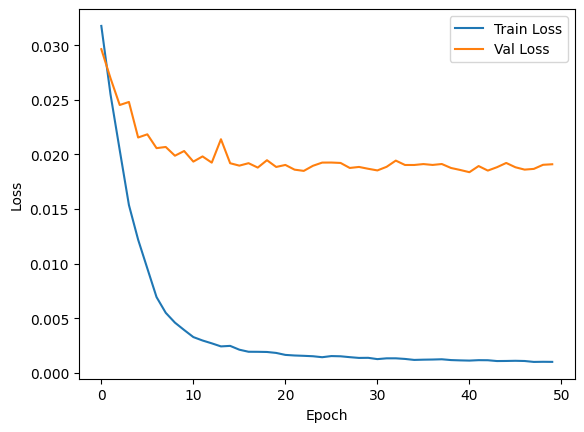

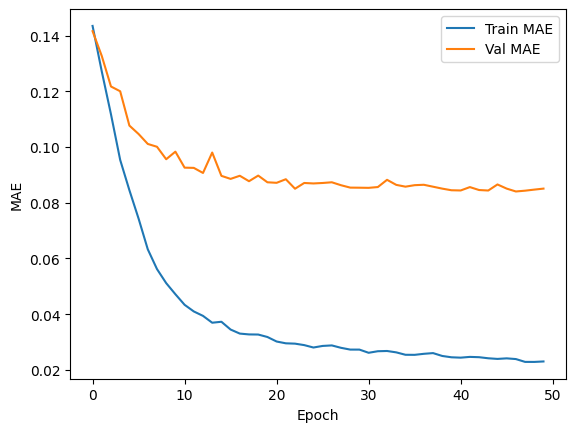

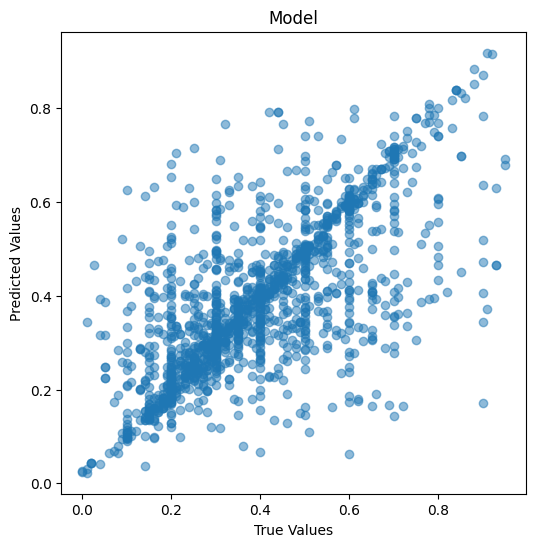

In [90]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
# print(y_val_tensor)

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50 # with 300 no learning effect

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        get_metrics_FCNN(X_train_tensor, y_train_tensor.numpy(), model, option='Train')
        get_metrics_FCNN(X_val_tensor, y_val_tensor.numpy(), model, option='Test')
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Scatter plot for the model
plt.figure(figsize=(6, 6))
plt.scatter(y_val_tensor.numpy(), model(X_val_tensor).detach().numpy(), alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model')
plt.show()

In [66]:
# Save
torch.save(model.state_dict(), 'params_morgan_fp_FCNN_simple.pt')

### 5.3.2 Parameter Grid Search

We conducted parameter grid searches for the previous model, also on Google Colab, but they did not yield better parameters. The parameters found were inserted above. 

### 5.3.3 Deep FCNN

In the case of all FCNNs, a lot of optimisation was going on, mostly on Google Colab, as the computational cost for parameter grid search was pretty high for my laptop.

Epoch 1, Train Loss: 0.0321928830327172, Val Loss: 0.02850492748742302, Train MAE: 0.1452537542110995, Val MAE: 0.13383199771245322, Train R^2: 0.19294870516341145, Val R^2: 0.15690465107356988
Epoch 2, Train Loss: 0.025609884764018813, Val Loss: 0.026844773441553116, Train MAE: 0.12749533159168144, Val MAE: 0.13174741715192795, Train R^2: 0.4071191408518038, Val R^2: 0.20359049099801962
Epoch 3, Train Loss: 0.02067479859841497, Val Loss: 0.025303530506789684, Train MAE: 0.11251474336573952, Val MAE: 0.1216372437775135, Train R^2: 0.519527075948526, Val R^2: 0.24947089397889122
Epoch 4, Train Loss: 0.015416369655806767, Val Loss: 0.022255837141225737, Train MAE: 0.09558786365546679, Val MAE: 0.11186012253165245, Train R^2: 0.6710806470801274, Val R^2: 0.3386038062886333
Epoch 5, Train Loss: 0.011944024166778514, Val Loss: 0.022504358397175867, Train MAE: 0.08379362366701427, Val MAE: 0.10986406976977985, Train R^2: 0.7535057464962729, Val R^2: 0.3299193334693219
Epoch 6, Train Loss: 0.

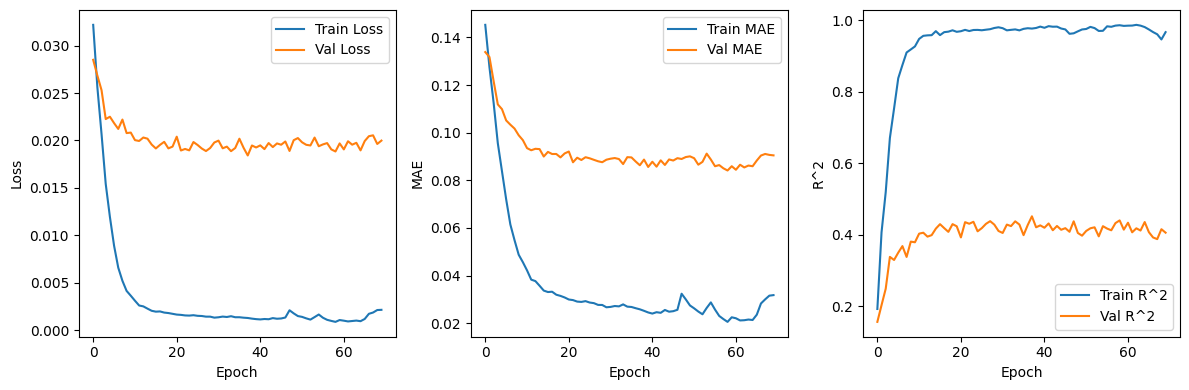

In [35]:
# Convert  to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN_deep(input_size=X_train.shape[1], dropout_prob=0.1)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_r2s = []
val_r2s = []

n_epochs = 70

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    # Compute R^2
    train_r2 = r2_score(y_train_tensor.detach().numpy(), model(X_train_tensor).detach().numpy())
    val_r2 = r2_score(y_val_tensor.detach().numpy(), model(X_val_tensor).detach().numpy())
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}, Train R^2: {train_r2}, Val R^2: {val_r2}')

# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot training and validation R^2
plt.subplot(1, 3, 3)
plt.plot(train_r2s, label='Train R^2')
plt.plot(val_r2s, label='Val R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.legend()

plt.tight_layout()
plt.show()

### 5.3.4 Self attention FCNN

Epoch 1, Train Loss: 0.022604171657248547, Val Loss: 0.014227159088477492, Train MAE: 0.16585879953284013, Val MAE: 0.1369874949256579
Epoch 2, Train Loss: 0.014397767215575043, Val Loss: 0.012747492408379912, Train MAE: 0.13499888769890134, Val MAE: 0.12514653305212656
Epoch 3, Train Loss: 0.01145357243030479, Val Loss: 0.012440237992753586, Train MAE: 0.11897816148243452, Val MAE: 0.12181190835932891
Epoch 4, Train Loss: 0.009681904208111136, Val Loss: 0.01311415332990388, Train MAE: 0.10846612037796723, Val MAE: 0.12268376785020034
Epoch 5, Train Loss: 0.007425663865318424, Val Loss: 0.012478133973975977, Train MAE: 0.09437253788897866, Val MAE: 0.11990832599500816
Epoch 6, Train Loss: 0.005874656792730093, Val Loss: 0.010859568680947026, Train MAE: 0.08379052124525371, Val MAE: 0.10807306692004204
Epoch 7, Train Loss: 0.00435687710384005, Val Loss: 0.011146606489395102, Train MAE: 0.07112867447890733, Val MAE: 0.10802239055434863
Epoch 8, Train Loss: 0.0036957466876820512, Val Loss

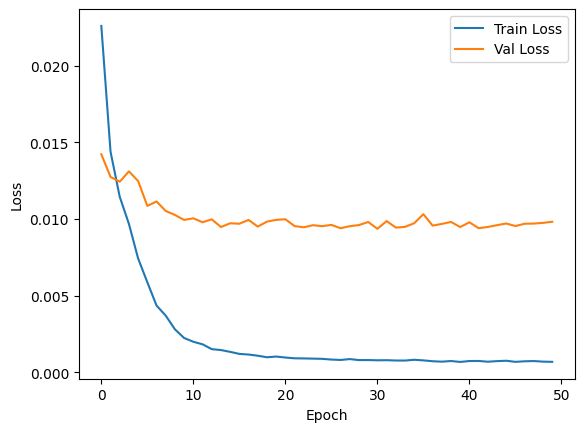

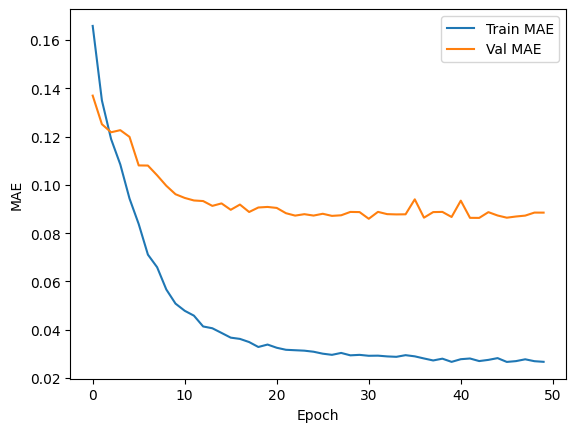

In [22]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
# print(y_val_tensor)

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN_att(input_size=X_train.shape[1], dropout_prob=0.2)
#loss_fn = nn.MSELoss()  # Mean Squared Error loss
loss_fn = nn.HuberLoss(delta=1.0)  # Huber loss
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### 5.3.6 FCNN with Morgan Fingerprints and RDKIt descriptors

Now I tried concatenating the Morgan Fingerprints with the RDKit Descriptors to get more information about chemical properties. Using the same models as before, the prediction got even worse, which is why - for better readability of the notebook, it was taken out. Probably, at one point there were too many input dimensions, making it impossible to predict. This is when dimension reduction was tried using embedded neural networks.

In [91]:
# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)

# concatenate all the 2D numpy arrays to a big 2D numpy array
descriptors = np.concatenate([compound_descriptors, solvent_A_descriptors, solvent_B_descriptors, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(descriptors.shape, type(descriptors), descriptors.ndim, y.ndim, y.shape)

(15062, 14) <class 'numpy.ndarray'> 2 2 (15062, 1)


### 5.3.7 FCNN with embedded NN

In thie embedded NN, at first the compound fingerprints and solvents are fed into separate Encoders which reduce the dimensionality, trying to find important features and then feeding the new features into a subsequent neural network. At first, we struggled with the backpropagation which was not set up in the right way. Now it should work. However, the improvement in performance was minimal. 

In [115]:
# Encoder for dimensionality reduction
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

# Define the Combined Network class (encoder + decoder)
class CombinedNet(nn.Module):
    def __init__(self, compound_input_dim, solvent_input_dim, embedding_dim, dropout_prob):
        super(CombinedNet, self).__init__()
        self.compound_encoder = Encoder(compound_input_dim, embedding_dim)
        self.solvent_encoder = Encoder(solvent_input_dim, embedding_dim)

        # The input dimension to the final network is the concatenated embeddings + 2 percentages
        combined_input_dim = 3 * embedding_dim + 2

        self.fc1 = nn.Linear(combined_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, compound_fp, solvent_a_fp, solvent_b_fp, percent_a_tensor, percent_b_tensor):
        compound_embedding = self.compound_encoder(compound_fp)
        solvent_a_embedding = self.solvent_encoder(solvent_a_fp)
        solvent_b_embedding = self.solvent_encoder(solvent_b_fp)

        # Concatenate embeddings with percentages
        combined = torch.cat((compound_embedding, solvent_a_embedding, solvent_b_embedding, percent_a_tensor, percent_b_tensor), dim=1)

        x = self.relu(self.fc1(combined))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.sigmoid(self.fc4(x))
        return x

In [116]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(f"compound feature shape: {compound_features.shape}, type {type(compound_features)}, dimension {compound_features.ndim}")
print(f"solvent a feature shape: {solvent_A_features.shape}, type {type(solvent_A_features)}, dimension {solvent_A_features.ndim}")

y = np.stack(df_fp['Rf'].values) # I don't know why I called this y, sorry man :D just out of habit I guess. 

(2048,) 1
compound feature shape: (15062, 2048), type <class 'numpy.ndarray'>, dimension 2
solvent a feature shape: (15062, 256), type <class 'numpy.ndarray'>, dimension 2


In [117]:
#Split dataset
X_train_compound, X_test_compound, X_train_solvent_A, X_test_solvent_A, X_train_solvent_B, X_test_solvent_B, X_train_percent_a, X_test_percent_a, X_train_percent_b, X_test_percent_b, y_train, y_test = train_test_split(
compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features, y, test_size=0.2, random_state=42)

In [118]:
# Convert numpy arrays to PyTorch tensors
X_train_compound_tensor = torch.from_numpy(X_train_compound).float()
X_train_solvent_A_tensor = torch.from_numpy(X_train_solvent_A).float()
X_train_solvent_B_tensor = torch.from_numpy(X_train_solvent_B).float()
X_train_percent_a_tensor = torch.from_numpy(X_train_percent_a).float()
X_train_percent_b_tensor = torch.from_numpy(X_train_percent_b).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_compound_tensor = torch.from_numpy(X_test_compound).float()
X_test_solvent_A_tensor = torch.from_numpy(X_test_solvent_A).float()
X_test_solvent_B_tensor = torch.from_numpy(X_test_solvent_B).float()
X_test_percent_a_tensor = torch.from_numpy(X_test_percent_a).float()
X_test_percent_b_tensor = torch.from_numpy(X_test_percent_b).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor, y_test_tensor)

# Create DataLoaders, define batch size
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Epoch 1, Train Loss: 0.03168932345533182, Val Loss: 0.025639007333666086, Train MAE: 0.1435253666270347, Val MAE: 0.1278452519327402
Epoch 2, Train Loss: 0.022429949042224694, Val Loss: 0.023209139646496624, Train MAE: 0.1169935512558493, Val MAE: 0.11747780147319038
Epoch 3, Train Loss: 0.01272776064083532, Val Loss: 0.01896004764906441, Train MAE: 0.08471860811508522, Val MAE: 0.09997888701036572
Epoch 4, Train Loss: 0.006965658872600191, Val Loss: 0.01892938625921185, Train MAE: 0.061577881612474954, Val MAE: 0.09463534511936207
Epoch 5, Train Loss: 0.004374703629528759, Val Loss: 0.018004423143186916, Train MAE: 0.0483939327082779, Val MAE: 0.09070129630466302
Epoch 6, Train Loss: 0.0031931475759607066, Val Loss: 0.017102680227253586, Train MAE: 0.04098549134359158, Val MAE: 0.08979107455040018
Epoch 7, Train Loss: 0.0025462705411618113, Val Loss: 0.017643270703653496, Train MAE: 0.03633963309780315, Val MAE: 0.09125830543537934
Epoch 8, Train Loss: 0.0022666253717419094, Val Loss:

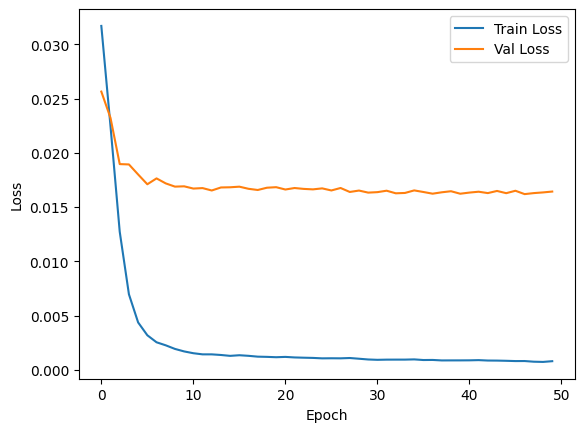

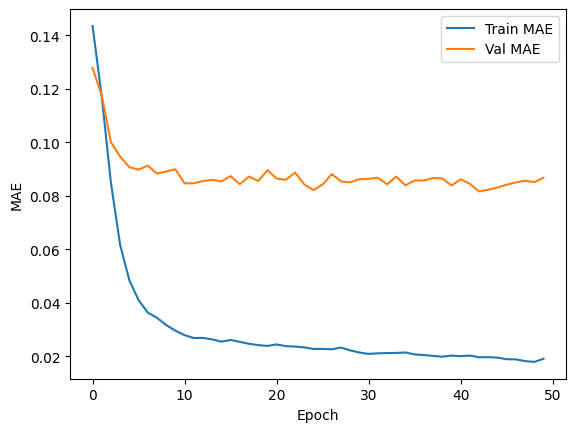

In [119]:
# Initialize the model, loss function, and optimizer
model = CombinedNet(compound_input_dim=2048, solvent_input_dim=256, embedding_dim=128, dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor, y_train_tensor in train_dataloader:
        optimizer.zero_grad()
        outputs = model(X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor)
        loss = loss_fn(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - y_train_tensor))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor, y_test_tensor in val_dataloader:
            outputs = model(X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor)
            loss = loss_fn(outputs, y_test_tensor)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - y_test_tensor))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### 5.3.8 Ensemble learning Morgan FP

The next thing that came to our minds was going one step further from embedded systems to ensemble methods as maybe the neural network was not the right model. For the ensemble learning, we wanted to still use the optimized parameters found for the simple FCNN, which is why we had to write a new class, which would wrap the FCNN into something that could be used by sklearn.

In [40]:
# Define the SklearnWrapper
class SklearnWrapper(BaseEstimator, RegressorMixin):
    """ A wrapper class that implements sklearn's BaseEstimator and RegressorMixin """
    def __init__(self, model, epochs=50, lr=0.01):
        self.model = model
        self.epochs = epochs
        self.lr = lr

    def fit(self, X, y):
        # Convert data to tensors
        X_tensor = torch.from_numpy(X).float()
        y_tensor = torch.from_numpy(y).float()

        # Define loss function and optimizer
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Train the model
        self.model.train()
        for epoch in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

        return self

    def predict(self, X):
        # Convert data to tensor
        X_tensor = torch.from_numpy(X).float()

        # Get predictions
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor)
        
        return predictions.numpy()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4385
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 2136
[LightGBM] [Info] Start training from score 0.403139


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([12049])) that is different to the input size (torch.Size([12049, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4376
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 2136
[LightGBM] [Info] Start training from score 0.402448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4373
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 2136
[LightGBM] [Info] Start training from score 0.404680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9639])) that is different to the input size (torch.Size([9639, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9640])) that is different to the input size (torch.Size([9640, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Mean Squared Error: 0.0034
Train Spearman Correlation: 0.9428
Train R^2: 0.8996
Test Mean Squared Error: 0.0182
Test Spearman Correlation: 0.658
Test R^2: 0.4521


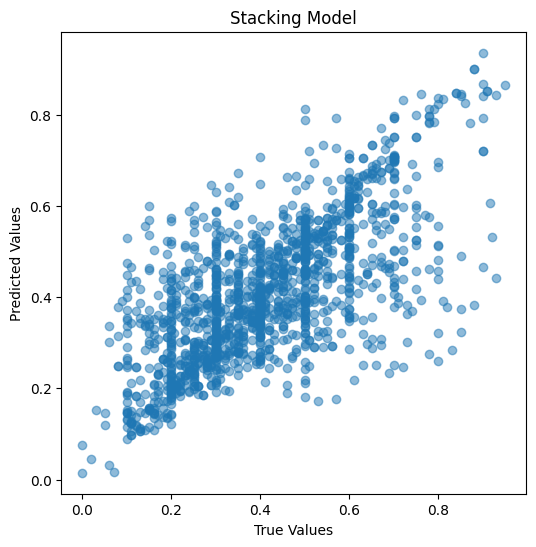

In [41]:
fcnn_model = FCNN(input_size=X_train.shape[1], dropout_prob=0.2)
sklearn_fcnn = SklearnWrapper(fcnn_model)

base_models = [
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42)),
    ('lgb', lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=1000, random_state=1, n_jobs=1)),
    ('fcnn', sklearn_fcnn)
]

# Define the meta model
meta_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the stacking ensemble
stacking_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train.ravel())

# Get metrics for train and test sets
get_metrics(X_train, y_train, stacking_ensemble, option='Train')
get_metrics(X_test, y_test, stacking_ensemble, option='Test')

# Predictions from the stacking model
y_pred_stacking = stacking_ensemble.predict(X_test)

# Scatter plot for the stacking model
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Stacking Model')
plt.show()

An R^2 score of 0.45 is not bad and we can clearly see the trend of the prediction. But we were wondering, if there was not something more accurate? 

## 5.4 ChemBERTa

For ChemBERTa, we first needed to create the new, ChemBERTa embedded features using the pretrained model created by HuggingFace. The first try to completely embed ChemBERTA did not work and crashed.

In [8]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "True"

In [9]:
df = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_cb = df.copy()
df_cb = df_cb[df_cb['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_cb['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


In [10]:
# Fill missing solvent SMILES with a placeholder (e.g., an empty string)
df_cb['Solvent_A_Smiles'] = df_cb['Solvent_A_Smiles'].fillna('')
df_cb['Solvent_B_Smiles'] = df_cb['Solvent_B_Smiles'].fillna('')

# Create binary indicators for solvent presence
df_cb.loc[:, 'Solvent_A_Present'] = df_cb['Solvent_A_Smiles'].apply(lambda x: 0 if x == '' else 1)
df_cb.loc[:, 'Solvent_B_Present'] = df_cb['Solvent_B_Smiles'].apply(lambda x: 0 if x == '' else 1)

# Extract relevant columns
product_smiles = df_cb['productSmiles_processed'].tolist()
solvent_a_smiles = df_cb['Solvent_A_Smiles'].tolist()
solvent_b_smiles = df_cb['Solvent_B_Smiles'].tolist()
percent_a = df_cb['Percent_A'].values
percent_b = df_cb['Percent_B'].values
solvent_a_present = df_cb['Solvent_A_Present'].values
solvent_b_present = df_cb['Solvent_B_Present'].values
rf_values = df_cb['Rf'].values

### 5.4.1 Transfer Learning with ChemBERTa Embeddings

First we need the tokenizer and the CHemBERTa model. It took quite a while to generate those new input features with ChemBERTa.

In [49]:
# Load pre-trained ChemBERTa model and tokenizer
chemberta_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Function to extract ChemBERTa embeddings
def extract_embeddings(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = chemberta_model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    mean_embeddings = last_hidden_states.mean(dim=1).numpy()  # Average pooling over tokens
    return mean_embeddings

def safe_extract_embeddings(x):
    if x is None or not isinstance(x, str):
        # Return a numpy array of zeros with the same dimension as the embeddings
        return np.zeros((1, 768))
    else:
        return extract_embeddings(x)

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [55]:
df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_fp['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


Convert the SMILES to embeddings.

In [56]:
# apply fingerprint and descriptor generation function
df_fp = create_fingerprints(df_fp, 'productSmiles_processed')
df_fp = create_fingerprints(df_fp, 'Solvent_A_Smiles')
df_fp = create_fingerprints(df_fp, 'Solvent_B_Smiles')

# Extract ChemBERTa embeddings for product smiles
df_fp['product_embeddings'] = df_fp['productSmiles_processed'].apply(safe_extract_embeddings)
compound_embeddings = np.stack(df_fp['product_embeddings'].values)

# Apply mean pooling across the token dimension
compound_embeddings = np.mean(compound_embeddings, axis=1)

# compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)

# convert the percent values to numpy arrays
df_fp['Percent_A'] = df_fp['Percent_A'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))
df_fp['Percent_B'] = df_fp['Percent_B'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))

# Stack the percent values to numpy arrays
percent_a = np.stack(df_fp['Percent_A'].values)
percent_b = np.stack(df_fp['Percent_B'].values)

# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))

# Concatenate all arrays into a single feature matrix
X = np.concatenate([compound_embeddings, solvent_A_descriptors, solvent_B_descriptors, percent_a, percent_b], axis=1)

y = np.stack(df_fp['Rf'].values)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [57]:
# Save the embeddings and other preprocessed data
np.savez_compressed('preprocessed_data.npz', 
                    X_train_chemberta=X_train, y_train_chemberta=y_train, 
                    X_val_chemberta=X_val, y_val_chemberta=y_val, 
                    X_test_chemberta=X_test, y_test_chemberta=y_test)

In [79]:
data = np.load('preprocessed_data.npz')

X_train = data['X_train_chemberta']
y_train = data['y_train_chemberta']
X_val = data['X_val_chemberta']
y_val = data['y_val_chemberta']
X_test = data['X_test_chemberta']
y_test = data['y_test_chemberta']

### 5.4.2 XGBoost

Train Mean Squared Error: 0.0329
Train Spearman Correlation: 0.3234
Validation Mean Squared Error: 0.0332
Validation Spearman Correlation: 0.2567


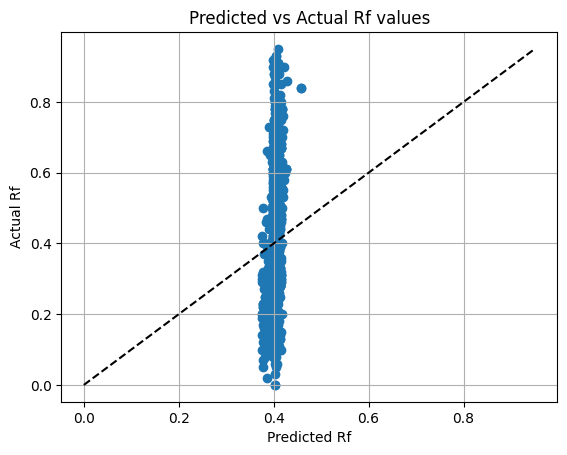

In [59]:
# Define XGBoost regressor parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.9,
    'learning_rate': 0.001,
    'max_depth': 4,
    'n_estimators': 200,
    'subsample': 0.8,
    'random_state': 42
}

# Create XGBoost regressor
xgb_model = xgb.XGBRegressor(**xgb_params)

# Train the XGBoost regressor
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, xgb_model, option='Train')
get_metrics(X_val, y_val, xgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = xgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Train Mean Squared Error: 0.0046
Train Spearman Correlation: 0.9527
Train R^2: 0.8649
Validation Mean Squared Error: 0.0191
Validation Spearman Correlation: 0.6491
Validation R^2: 0.4348


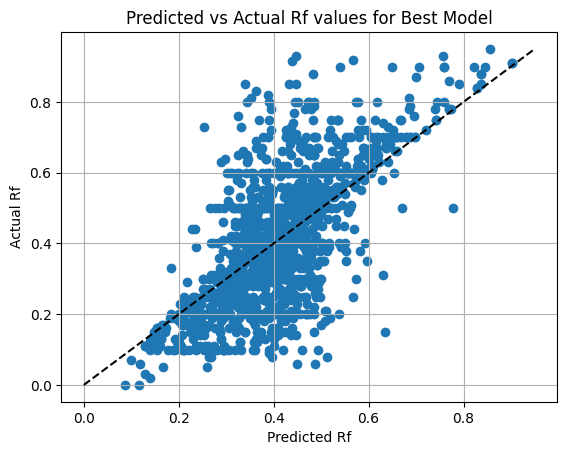

In [48]:
# Define the parameter grid
param_grid = {
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0]
}

# Create base model
xgb_model = xgb.XGBRegressor(random_state=42)

# Instantiate
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Train and evaluate
xgb_model_best = xgb.XGBRegressor(**best_params)
xgb_model_best.fit(X_train, y_train)

get_metrics(X_train, y_train, xgb_model_best, option='Train')
get_metrics(X_val, y_val, xgb_model_best, option='Validation')

# Scatterplot 
pred = xgb_model_best.predict(X_test)
actual = y_test

plt.scatter(pred, actual, alpha=0.3)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values for Best Model')
plt.grid()
plt.show()

### 5.4.3 LightGBM

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196021
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 778


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Start training from score 0.403139
Train Mean Squared Error: 0.0002
Train Spearman Correlation: 0.9964
Train R^2: 0.9937
Validation Mean Squared Error: 0.0179
Validation Spearman Correlation: 0.6772
Validation R^2: 0.4703


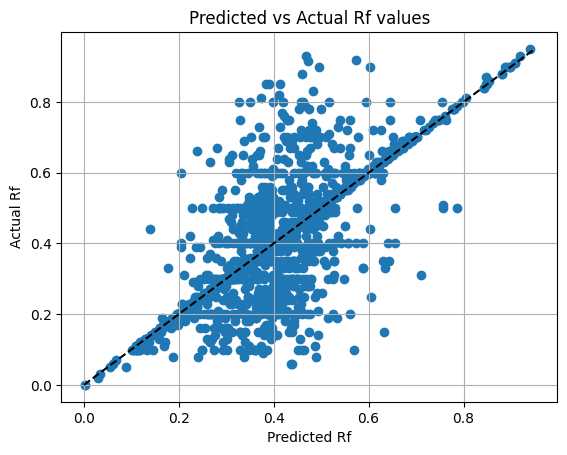

In [19]:
# Light GBM
# Define LightGBM regressor parameters
lgb_params = {
    'objective': 'regression',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'random_state': 1,
    'n_jobs': 1
}

# Create LightGBM regressor
lgb_model = lgb.LGBMRegressor(**lgb_params)

# Train
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Get metrics 
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = lgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual, alpha=0.3)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.391035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.287277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196012
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196007
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196009
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 778
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196016
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 778
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196021
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 778
[LightGBM] [Info] Start training from score 0.403139
Best parameters found:  {'learning_rate': 0.05, 'n_estimators': 2000, 'num_leaves': 50}


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196021
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 778


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Start training from score 0.403139
Train Mean Squared Error: 0.0001
Train Spearman Correlation: 0.9976
Train R^2: 0.9967
Validation Mean Squared Error: 0.0172
Validation Spearman Correlation: 0.692
Validation R^2: 0.4911


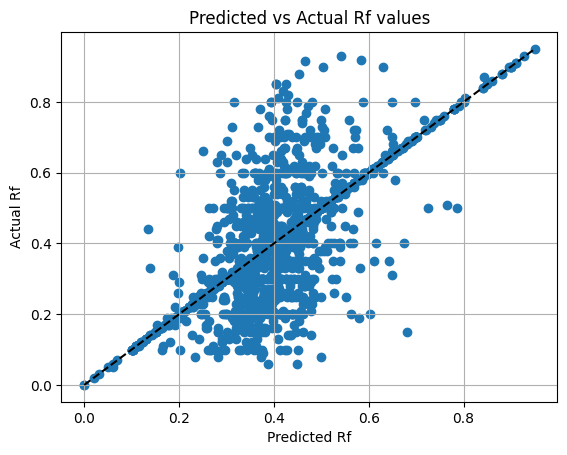

In [81]:
# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [500, 1000, 2000],
}

# Create LightGBM regressor
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=1, n_jobs=1)

# Create the grid search object
grid = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search
grid.fit(X_train, y_train)

# Print best parameters
print("Best parameters found: ", grid.best_params_)

# Train LightGBM regressor with the best parameters
lgb_model = lgb.LGBMRegressor(**grid.best_params_, objective='regression', random_state=1, n_jobs=1)
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Get metrics 
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Scatterplot  
pred = lgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196021
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 778


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Start training from score 0.403139
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[570]	training's l2: 0.000219677	valid_1's l2: 0.0173042
Train Mean Squared Error: 0.0002
Train Spearman Correlation: 0.9964
Train R^2: 0.9935
Validation Mean Squared Error: 0.0173
Validation Spearman Correlation: 0.6888
Validation R^2: 0.4878


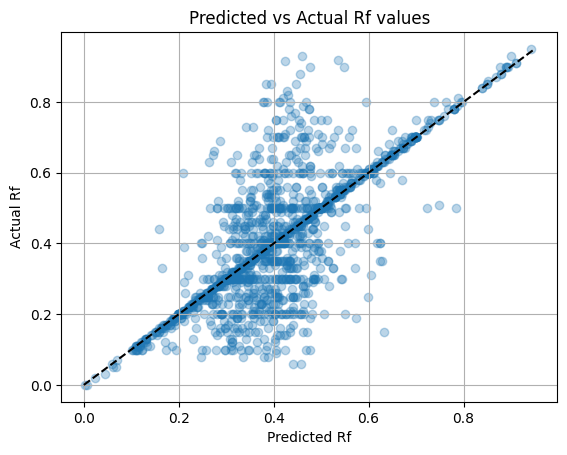

In [80]:
# Light GBM - best params

def train_lgbm(X_train, y_train, X_val, y_val, lgb_params):
    # Initiate LightGBM regressor
    lgb_model = lgb.LGBMRegressor(**lgb_params)

    # Train LightGBM regressor
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=100)]) # early stopping to prevent overfitting
    
    return lgb_model

def plot_predictions(model, X_test, y_test):
    # Scatterplot of predicted vs. actual values 
    pred = model.predict(X_test)
    actual = y_test

    plt.scatter(pred, actual, alpha=0.3)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
    plt.xlabel('Predicted Rf')
    plt.ylabel('Actual Rf')
    plt.title('Predicted vs Actual Rf values')
    plt.grid()
    plt.show()

# Define LightGBM regressor parameters
lgb_params = {
    'objective': 'regression',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'random_state': 1,
    'n_jobs': 1
}

# Train the model
lgb_model = train_lgbm(X_train, y_train, X_val, y_val, lgb_params)

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Plot predictions
plot_predictions(lgb_model, X_test, y_test)

## 5.5 MACCS Keys and encoded solvents

Here I used a different approach: I encoded the compound SMILES in MACCS Keys but the solvent in a multi-hot encoded matrix of the length of the solvents. If a solvent is present, the ratio of this solvent is included. This reduces the complexity and size of the input.

In [50]:
df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]

# Convert SMILES to MACCS fingerprints
df_fp['MACCS'] = df_fp['productSmiles_processed'].apply(lambda x: MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)))

# List of solvents
solvents = ['DCM', 'MeOH', 'MeCN', 'Toluene', 'Hexane', 'Chloroform', 'Acetone', 'EtOH', 'diethyl ether', 'heptane', 'petroleum ether (2-methylpentane)', 'triethylamine', 'EtOAc', 'THF']

# Create a new column for the solvent features
df_fp['solvent_feature'] = [[] for _ in range(len(df_fp))]

for index, row in df_fp.iterrows():
    solvent_feature = np.zeros(len(solvents))
    
    # Check solvent_A
    solvent_A = row['Solvent_A']
    if solvent_A in solvents:
        solvent_A_index = solvents.index(solvent_A)
        solvent_feature[solvent_A_index] = row['Percent_A']
        
        # If Percent_A is 100, there won't be a solvent_B
        if row['Percent_A'] == 100:
            df_fp.at[index, 'solvent_feature'] = solvent_feature.tolist()
            continue
    
    # Check solvent_B
    solvent_B = row['Solvent_B']
    if solvent_B in solvents:
        solvent_B_index = solvents.index(solvent_B)
        solvent_feature[solvent_B_index] = row['Percent_B']
        
    df_fp.at[index, 'solvent_feature'] = solvent_feature.tolist()

df_fp = create_fingerprints(df_fp, 'productSmiles_processed')

df_fp.head()

,Unnamed: 0,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,...,Percent_C,sum,Solvent_A_Smiles,Solvent_B_Smiles,extracted_pr_Smiles,productSmiles_processed,MACCS,solvent_feature,productSmiles_processed_Morgan_Fingerprint_np,productSmiles_processed_RDKit_Descriptors
0,2,A solution of 4-{[(phenylmethoxy)carbonylamino...,[C:1]1([CH2:7][O:8][C:9]([NH:11][CH2:12][C:13]...,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],Preparation of N-methoxy-N-methyl(4-{[(phenylm...,0.3,petroleum ether (2-methylpentane),EtOAc,50.0,50.0,...,NaN,100.0,CCCC(C)C,O=C(OCC)C,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[328.36799999999994, 2.7464000000000013, 1.0, ..."
1,3,Putative nitrilase up-mutants were assayed in ...,[CH3:1][C:2]1(C)S[C@@H]2[C@H](NC([C@H](N)C3C=C...,['N#CC[C@@H](O)CC(=O)O'],NaN,0.5,EtOAc,Hexane,50.0,50.0,...,NaN,100.0,O=C(OCC)C,CCCCCC,['N#CC[C@@H](O)CC(=O)O'],N#CC[C@@H](O)CC(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[129.115, -0.26431999999999994, 2.0, 3.0]"
2,5,To 0.4 g N6-benzoyl-3′-O-(methylthiomethyl)-5′...,[C:1]([NH:9][C:10]1[C:11]2[N:12]=[CH:13][N:14]...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,NaN,0.3,EtOAc,Hexane,70.0,30.0,...,NaN,100.0,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cccc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[410.3940000000001, 2.0114000000000005, 2.0, 9.0]"
3,6,3.5 g N4-benzoyl-5′-O-tert-butyldimethylsilyl-...,[C:1]([NH:9][C:10]1[CH:30]=[CH:29][N:13]([C@@H...,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,NaN,0.4,EtOAc,Hexane,90.0,10.0,...,NaN,100.0,O=C(OCC)C,CCCCCC,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)O[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[505.7130000000003, 4.510600000000005, 1.0, 8.0]"
4,7,To 0.5580 g N4-benzoyl-3′-O-(methylthiomethyl)...,[C:1]([NH:9][C:10]1[CH:33]=[CH:32][N:13]([C@@H...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,NaN,0.5,EtOAc,Hexane,5.0,95.0,...,NaN,100.0,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 95.0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[386.36800000000017, 1.4283999999999997, 2.0, ..."


Stack the data and split it.

In [25]:
maccs = np.stack(df_fp['MACCS'].apply(lambda x: np.array(x)).values)
rdk_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].apply(lambda x: np.array(x)).values)
solvent_features_matr = np.stack(df_fp['solvent_feature'].values)

# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))

# Concatenate all arrays into a single feature matrix
X = np.concatenate([maccs, rdk_descriptors, solvent_features_matr], axis=1)

y = np.stack(df_fp['Rf'].values)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def process_features(df):
    """
    Process features and convert them into numpy arrays.
    """
    maccs = np.stack(df['MACCS'].apply(lambda x: np.array(x)).values)
    rdk_descriptors = np.stack(df['productSmiles_processed_RDKit_Descriptors'].apply(lambda x: np.array(x)).values)
    solvent_features_matr = np.stack(df['solvent_feature'].values)

    # Concatenate all arrays into a single feature matrix
    X = np.concatenate([maccs, rdk_descriptors, solvent_features_matr], axis=1)

    return X

def process_labels(df):
    """
    Process labels and convert them into numpy arrays.
    """
    # convert the Rf values to numpy arrays
    df['Rf'] = df['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))
    y = np.stack(df['Rf'].values)

    return y

def split_data(X, y):
    """
    Split data into train, validation, and test sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Process features and labels
X = process_features(df_fp)
y = process_labels(df_fp)

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

In [26]:
# Save the datasets
np.save('maccs_X_train.npy', X_train)
np.save('maccs_X_val.npy', X_val)
np.save('maccs_X_test.npy', X_test)
np.save('maccs_y_train.npy', y_train)
np.save('maccs_y_val.npy', y_val)
np.save('maccs_y_test.npy', y_test)

In [2]:
# Load the datasets
X_train = np.load('maccs_X_train.npy')
X_val = np.load('maccs_X_val.npy')
X_test = np.load('maccs_X_test.npy')
y_train = np.load('maccs_y_train.npy')
y_val = np.load('maccs_y_val.npy')
y_test = np.load('maccs_y_test.npy')

### 5.5.1 Light Gradient Boosting Model

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 168
[LightGBM] [Info] Start training from score 0.403139
Train Mean Squared Error: 0.0024
Train Spearman Correlation: 0.9698
Train R^2: 0.929
Validation Mean Squared Error: 0.0159
Validation Spearman Correlation: 0.7211
Validation R^2: 0.5304


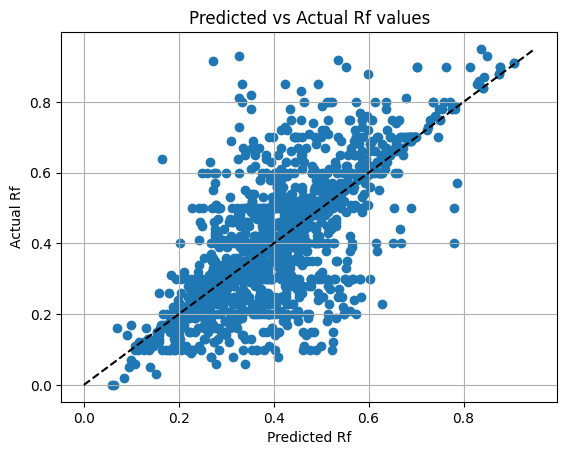

In [27]:
# Define LightGBM regressor parameters
lgb_params = {
    'objective': 'regression',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'random_state': 1,
    'n_jobs': 1
}

# Create a LightGBM regressor
lgb_model = lgb.LGBMRegressor(**lgb_params)

# Train the LightGBM regressor
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = lgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual, alpha=0.3)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

### 5.5.2 Parameter Grid Search for LightGBM

In [ ]:
def train_lgbm(X_train, y_train, X_val, y_val, lgb_params):
    # Initiate LightGBM regressor
    lgb_model = lgb.LGBMRegressor(**lgb_params)

    # Train LightGBM regressor
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=100)]) # early stopping to prevent overfitting
    
    return lgb_model

def plot_predictions(model, X_test, y_test):
    # Scatterplot of predicted vs. actual values 
    pred = model.predict(X_test)
    actual = y_test

    plt.scatter(pred, actual, alpha=0.3)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
    plt.xlabel('Predicted Rf')
    plt.ylabel('Actual Rf')
    plt.title('Predicted vs Actual Rf values')
    plt.grid()
    plt.show()

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 168
[LightGBM] [Info] Start training from score 0.403139
Best parameters found:  {'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 100}


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 168
[LightGBM] [Info] Start training from score 0.403139


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Train Mean Squared Error: 0.0009
Train Spearman Correlation: 0.9881
Train R^2: 0.9734
Validation Mean Squared Error: 0.0149
Validation Spearman Correlation: 0.742
Validation R^2: 0.5595


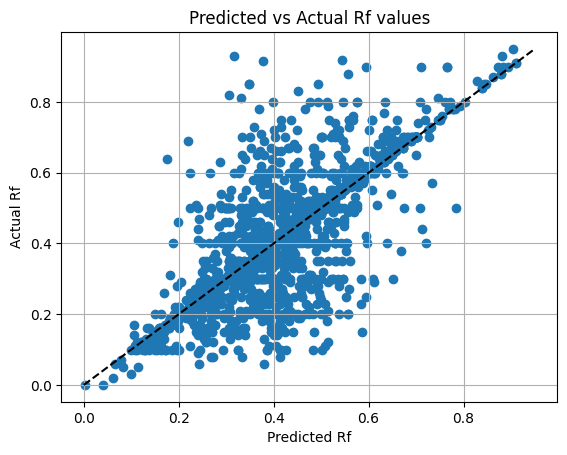

In [28]:
# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [500, 1000, 2000],
}

# Create a LightGBM regressor
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=1, n_jobs=1)

# Create the grid search object
grid = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search
grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid.best_params_) #Best parameters found:  {'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 100}, R^2 = 0.55

# Train the LightGBM regressor with the best parameters
lgb_model = lgb.LGBMRegressor(**grid.best_params_, objective='regression', random_state=1, n_jobs=1)
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = lgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 168
[LightGBM] [Info] Start training from score 0.403139
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	training's l2: 0.000899074	valid_1's l2: 0.0148787
Train Mean Squared Error: 0.0009
Train Spearman Correlation: 0.9881
Train R^2: 0.9734
Validation Mean Squared Error: 0.0149
Validation Spearman Correlation: 0.742
Validation R^2: 0.5596


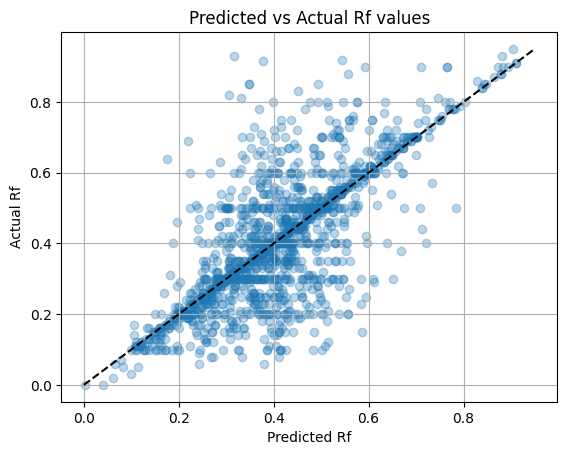

In [77]:
# Light GBM - best params
# Define LightGBM regressor parameters
lgb_params = {
    'objective': 'regression',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'random_state': 1,
    'n_jobs': 1
}

# Train the model
lgb_model = train_lgbm(X_train, y_train, X_val, y_val, lgb_params)

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Plot predictions
plot_predictions(lgb_model, X_test, y_test)

With an R^2 of 0.5596, this model outperformed all the others. Of course, it is still not ideal but there are certain limitations.

In [78]:
# Save the model
lgb_model.booster_.save_model('lgb_model_maccs_best_params.txt')

# Save model to JSON format just in case other format is needed for goi
lgb_model.booster_.save_model('lgb_model_maccs_best_params.json')

# Save model to C++ code
lgb_model.booster_.save_model('lgb_model_maccs_best_params.cpp')

In [ ]:
# Load the model
loaded_model = lgb.Booster(model_file='lgb_model_maccs_best_params.txt')

### 5.5.3 FCNN

Also applied the FCNN to the new features. It worked out nicely, but just took a very long time to compute so at one point I could not increase the epochs anymore.

Epoch 1, Train Loss: 0.15722452274051837, Val Loss: 0.14520226636280617, Train MAE: 0.15722452274051837, Val MAE: 0.14520226636280617, Train R^2: 0.013415639457622364, Val R^2: 0.01814921941352088
Epoch 2, Train Loss: 0.1472295686128285, Val Loss: 0.1441903606367608, Train MAE: 0.1472295686128285, Val MAE: 0.1441903606367608, Train R^2: 0.05693590686065775, Val R^2: 0.048793739364032196
Epoch 3, Train Loss: 0.1447252902530865, Val Loss: 0.14287073848148188, Train MAE: 0.1447252902530865, Val MAE: 0.14287073848148188, Train R^2: 0.08685420598540428, Val R^2: 0.07351171678801138
Epoch 4, Train Loss: 0.14208204168776933, Val Loss: 0.14009412052109838, Train MAE: 0.14208204168776933, Val MAE: 0.14009412052109838, Train R^2: 0.10341565712063217, Val R^2: 0.10213371877708577
Epoch 5, Train Loss: 0.1410836608245455, Val Loss: 0.1456207207714518, Train MAE: 0.1410836608245455, Val MAE: 0.1456207207714518, Train R^2: 0.08417793236944471, Val R^2: 0.06601754128505022
Epoch 6, Train Loss: 0.13913

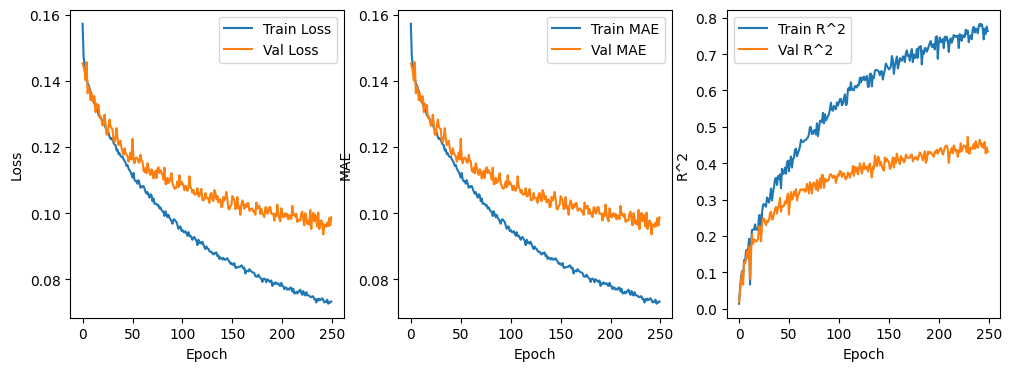

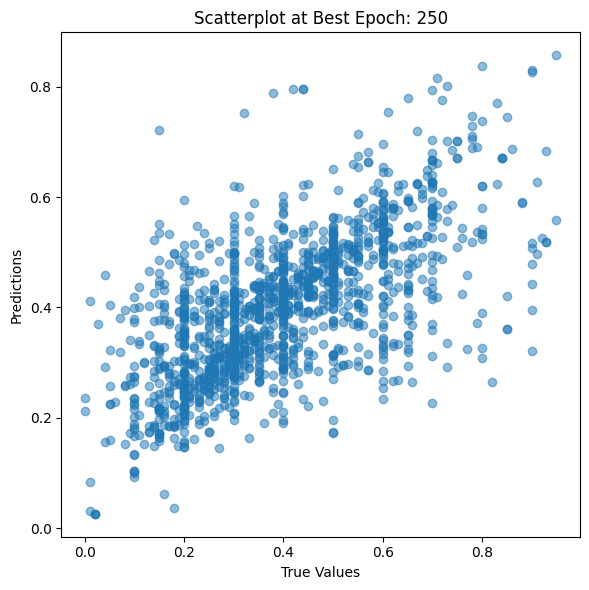

In [12]:
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Initialize the model, loss function, and optimizer
model = FCNN(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = torch.nn.L1Loss()  # Mean absolute Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_r2s = []
val_r2s = []

best_epoch = 0
best_val_r2 = -np.inf
best_predictions = None

n_epochs = 250

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    # Compute R^2
    train_r2 = r2_score(y_train_tensor.detach().numpy(), model(X_train_tensor).detach().numpy())
    val_r2 = r2_score(y_val_tensor.detach().numpy(), model(X_val_tensor).detach().numpy())
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)
    
    # If this epoch's validation R^2 is better than the best so far,
    # update best epoch and save its predictions
    if val_r2 > best_val_r2:
        best_epoch = epoch
        model.eval()
        with torch.no_grad():
            best_predictions = model(X_val_tensor).detach().numpy()


    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}, Train R^2: {train_r2}, Val R^2: {val_r2}')

# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot training and validation R^2
plt.subplot(1, 3, 3)
plt.plot(train_r2s, label='Train R^2')
plt.plot(val_r2s, label='Val R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.legend()

# After plotting the losses, MAE, and R^2, plot the scatterplot of the best epoch
plt.figure(figsize=(6, 6))
plt.scatter(y_val_tensor.detach().numpy(), best_predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Scatterplot at Best Epoch: {best_epoch+1}')

plt.tight_layout()
plt.show()

### 5.5.5 Ensemble method

This was based on best found parameters from previous grid searches.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 168
[LightGBM] [Info] Start training from score 0.403139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

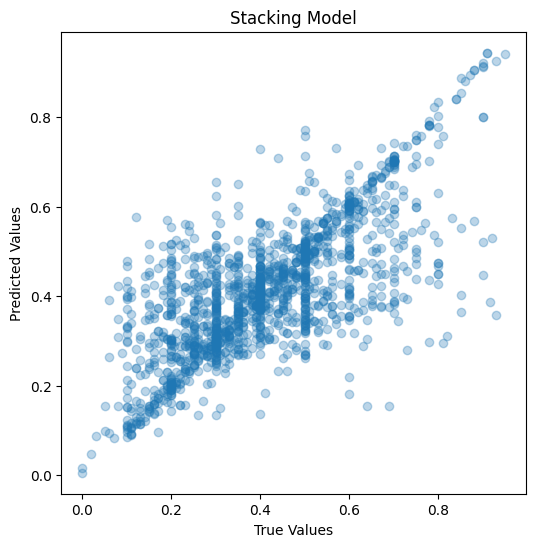

In [73]:
# Define the base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42)),
    ('lgb', lgb.LGBMRegressor(objective='regression', num_leaves=100, learning_rate=0.05, n_estimators=1000, random_state=1, n_jobs=1)),
    ('nn', MLPRegressor(hidden_layer_sizes=(128,), activation='relu', solver='adam', max_iter=200, random_state=42))
]

# Define the meta model
meta_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the stacking ensemble
stacking_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train.ravel())

# Get metrics for train and test sets
get_metrics(X_train, y_train, stacking_ensemble, option='Train')
get_metrics(X_test, y_test, stacking_ensemble, option='Test')

# Predictions from the stacking model
y_pred_stacking = stacking_ensemble.predict(X_test)

# Scatter plot for the stacking model
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Stacking Model')
plt.show()

## 5.5. Functions for input processing

Now for applying the model, a function is needed to convert inputs into the right format for the model and the streamlit user interface.

In [103]:
def get_maccs(smiles):
    """
    Generate MACCS keys for a molecule from its SMILES string.
    
    Args:
        smiles (str): The SMILES string of the molecule.
        
    Returns:
        np.array: A numpy array of the MACCS keys.
    """
    maccs = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles))
    return np.array([int(x) for x in list(maccs.ToBitString())])  # Convert MACCS keys to numpy array

def get_solvent_features(solvent_A, solvent_B, percent_A, solvents):
    """
    Generate solvent features for a given solvent combination.
    
    Args:
        solvent_A (str): The first solvent.
        solvent_B (str): The second solvent.
        percent_A (float): The percentage of solvent A.
        solvents (list): The list of all possible solvents.
        
    Returns:
        np.array: A numpy array of the solvent features.
    """
    percent_B = 100 - percent_A
    solvent_feature = np.zeros(len(solvents))
    if solvent_A in solvents:
        solvent_A_index = solvents.index(solvent_A)
        solvent_feature[solvent_A_index] = percent_A
    if solvent_B in solvents:
        solvent_B_index = solvents.index(solvent_B)
        solvent_feature[solvent_B_index] = percent_B
    return solvent_feature

def get_rdkit_descriptors(smiles):
    """
    Generate RDKit descriptors for a molecule from its SMILES string.
    
    Args:
        smiles (str): The SMILES string of the molecule.
        
    Returns:
        np.array: A numpy array of the RDKit descriptors.
    """
    mol = Chem.MolFromSmiles(smiles)
    return np.array([Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                     Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol)])

def process_input(smiles, solvent_A, solvent_B, percent_A):
    """
    Process the input data into a feature matrix.
    
    Args:
        smiles (str): The SMILES string of the molecule.
        solvent_A (str): The first solvent.
        solvent_B (str): The second solvent.
        percent_A (float): The percentage of solvent A.
        
    Returns:
        np.array: The feature matrix.
    """
    solvents = ['DCM', 'MeOH', 'MeCN', 'Toluene', 'Hexane', 'Chloroform', 'Acetone', 'EtOH', 'diethyl ether', 'heptane', 'petroleum ether (2-methylpentane)', 'triethylamine', 'EtOAc', 'THF']
    maccs = get_maccs(smiles)
    solvent_features = get_solvent_features(solvent_A, solvent_B, percent_A, solvents)
    rdkit_descriptors = get_rdkit_descriptors(smiles)
    X = np.concatenate([maccs, rdkit_descriptors, solvent_features])
    return X

To summarize, many different models were tried out. This was partly to try to enhance the performance of the model, but for me also a nice preparation for the AI for Chemistry course to try out as many different models and approaches as possible to get familiar with all of that, as I just started coding. At the end, Rf values when reported are very prone for distortions due to human error and unaccurate measurements, wrong solvent ratios, different moisture percentages and different plates. To have a better prediction, two things could be done:
1. automation of the process to guarantee exclusion of human error and different conditions
2. rounding the float Rf values from two digits after the commata to only one as also many chemists did this, as it can be drawn from the trends in the actual values axis in the graphs. Then the prediction would only output 9 different Rf values but still give a good indication.

Thanks for reading and sorry for the mess in this notebook. I am still working on it and wanted to keep my previous approaches without having too many notebooks flying around.